# Main plotting script MATCH2BRAIN -- USED FOR SI Figures!
## i.e., RandNouns & LengthControl BMs

`For main conditions: BETTER: run create_match2brain_PlotAndStats.py via create_fig1.sh`

## Import packages

In [32]:
save = True

In [33]:
#import packages
import os
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date
import numpy as np
import pandas as pd
from matplotlib.gridspec import GridSpec
import json

In [34]:
# import from other scripts
import plot_utils
import stats_utils

## Define approach configuration

In [35]:
model_identifier="gpt2-xl"

In [36]:
#whether or not to include control condition random nouns (used for SI)
randomnouns=False
length_control=True

In [37]:
#load configuration
with open('configurations.json', 'r') as f:
    config = json.load(f)
    
list(config.keys())

['TrainIntact-TestPerturbed:contextualized',
 'TrainIntact-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:contextualized',
 'TrainPerturbed-TestPerturbed:decontextualized',
 'TrainPerturbed-TestPerturbed:cv-by-passage']

In [38]:
# get setting
approach = "TrainIntact-TestPerturbed:contextualized" #main is "TrainIntact-TestPerturbed:contextualized"

emb_context=config[approach]["emb_context"]
split_coord=config[approach]["split_coord"]
testonperturbed=config[approach]["testonperturbed"]

## Get stimuli

In [39]:
stimuli_df = plot_utils.get_sample_stimuli(randomnouns=randomnouns,length_control=length_control)
stimuli_df

Original | original
Scr1 | scrambled1
Scr3 | scrambled3
Scr5 | scrambled5
Scr7 | scrambled7
backward | backward
lowPMI | lowpmi
lowPMI_random | lowpmi-random
contentwords | contentwords
nounsverbsadj | nounsverbsadj
nounsverbs | nounsverbs
nouns | nouns
functionwords | functionwords
sentenceshuffle-withinpassage | sent_passage
sentenceshuffle-withintopic | sent_topic
sentenceshuffle-random | sent_random
random | random-wl
length_control | length-control


,condition,stimulus
0,original,beekeeping encourages the conservation of loca...
1,scrambled1,beekeeping encourages the conservation of habi...
2,scrambled3,beekeeping conservation encourages the of habi...
3,scrambled5,conservation beekeeping encourages the habitat...
4,scrambled7,beekeeping conservation of encourages habitats...
5,backward,habitats local of conservation the encourages ...
6,lowpmi,beekeeping conservation habitats the of encour...
7,lowpmi-random,encourages the beekeeping of habitats conserva...
8,contentwords,beekeeping encourages conservation local habit...
9,nounsverbsadj,beekeeping encourages conservation local habit...


In [40]:
# function check (this is done in the main function below!)
scores_df = plot_utils.get_best_scores_df(model_identifier=model_identifier,
                                          emb_context=emb_context,
                                          split_coord=split_coord,
                                          testonperturbed=testonperturbed,
                                          randomnouns=randomnouns,length_control=length_control)
scores_df

,score,error,condition,category
0,1.107199,0.141840,original,original
1,0.127771,0.129982,length-control,control
2,0.108709,0.070373,random-wl,control


### merge with stimuli df

In [41]:
full_df = scores_df.merge(stimuli_df, on='condition', how='inner')
full_df

,score,error,condition,category,stimulus
0,1.107199,0.141840,original,original,beekeeping encourages the conservation of loca...
1,0.127771,0.129982,length-control,control,the the the the the the the.
2,0.108709,0.070373,random-wl,control,three climb around the the spears vapor.


In [42]:
#Rename conditions according to new names:
full_df['condition'] = full_df['condition'].map(plot_utils.COND2LABEL)

In [43]:
full_df["labelname"] = [': '.join(i) for i in zip(full_df["condition"].map(str),full_df["stimulus"])]
full_df

,score,error,condition,category,stimulus,labelname
0,1.107199,0.141840,Original,original,beekeeping encourages the conservation of loca...,Original: beekeeping encourages the conservati...
1,0.127771,0.129982,LengthControl,control,the the the the the the the.,LengthControl: the the the the the the the.
2,0.108709,0.070373,RandWordList,control,three climb around the the spears vapor.,RandWordList: three climb around the the spear...


## Get stats

In [44]:
import scipy
import statsmodels

#Benjamini/Hochberg corrected
def get_ttest_results(model_identifier, emb_context="Passage", split_coord="Sentence",
                testonperturbed=False, category=None, randomnouns=False, length_control=False):
    
    subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns, length_control=length_control)

    pvals2original, pvals2random = [], []
    ttest2original, ttest2random = [], []
    cohensd2original, cohensd2random = [], []
    conds = []
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=False,
                                                   randomnouns = randomnouns,
                                                   length_control=length_control)
    for cond in CAT2COND[category]:
        if length_control and "random-wl" in cond:
            continue
        
        #adjust names for consistency
        if cond == 'sentenceshuffle_random':
            cond = 'sent_random'
        elif cond == 'sentenceshuffle_passage':
            cond = 'sent_passage'
        elif cond == 'sentenceshuffle_topic':
            cond = 'sent_topic'

        #get subject scores
        original_scores = list(subdf[subdf['condition'] == 'original']["values"])
        cond_scores = list(subdf[subdf['condition'] == cond]["values"])
        random_scores = list(subdf[subdf['condition'] == 'random-wl']["values"])
        
        #get ttest
        ttest2orig, pval2orig = scipy.stats.ttest_ind(original_scores,cond_scores)
        ttest2rand, pval2rand = scipy.stats.ttest_ind(random_scores,cond_scores)
        
        # get effect size
        cohensd2orig = stats_utils.cohens_d(original_scores, cond_scores)
        cohensd2rand = stats_utils.cohens_d(random_scores, cond_scores)
        
        conds.append(cond)
        pvals2original.append(pval2orig)
        ttest2original.append(ttest2orig)
        pvals2random.append(pval2rand)
        ttest2random.append(ttest2rand)
        cohensd2original.append(cohensd2orig)
        cohensd2random.append(cohensd2rand)
        
    # correct for multiple comparisons
    # statsmodels.stats.multitest.fdrcorrection(pvals) = statsmodels.stats.multitest.multipletests(pvals, method='fdr_bh')
    # first output is list of Booleans indicating whether to reject null hypothesis or not
    _, adjusted_pvals2original = statsmodels.stats.multitest.fdrcorrection(pvals2original)
    _, adjusted_pvals2random = statsmodels.stats.multitest.fdrcorrection(pvals2random)
    
    #assign significance levels
    significance2original = stats_utils.assign_significance_labels(adjusted_pvals2original)
    significance2random = stats_utils.assign_significance_labels(adjusted_pvals2random)
    
    
    stats_df = pd.DataFrame({
        "condition": conds,
        "ttest2original" : ttest2original,
        "ttest2random" : ttest2random,
        "adjusted_pvals2original" : adjusted_pvals2original,
        "adjusted_pvals2random" : adjusted_pvals2random,
        "cohensd2original" : cohensd2original,
        "cohensd2random" : cohensd2random,
        "significance2original" : significance2original,
        "significance2random" : significance2random,
        "pvals2original" : pvals2original,
        "pvals2random" : pvals2random
    })
    
    return stats_df

In [45]:
subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns, length_control=length_control)

random_scores = list(subdf[subdf['condition'] == 'random-wl']["values"])
tstat, pval = scipy.stats.ttest_1samp(random_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for random-wl for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}\n")


random_sent_scores = list(subdf[subdf['condition'] == 'sent_random']["values"])
tstat, pval = scipy.stats.ttest_1samp(random_sent_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for sent_random for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}")

Testing for difference to 0 for random-wl for gpt2-xl
One-sample ttest: 3.1723661545617867
pvalue: 0.011322832097651767

Testing for difference to 0 for sent_random for gpt2-xl
One-sample ttest: nan
pvalue: nan


In [46]:
subdf

,condition,values,category
14,original,0.357018,original
19,original,0.348416,original
18,original,0.372733,original
17,original,0.369114,original
16,original,0.397626,original
15,original,0.395303,original
13,original,0.339043,original
12,original,0.308316,original
11,original,0.292175,original
10,original,0.311779,original


In [47]:
length_control_scores = list(subdf[subdf['condition'] == 'length-control']["values"])
tstat, pval = scipy.stats.ttest_1samp(length_control_scores, popmean=0, axis=0, nan_policy='propagate', alternative='two-sided')
print(f"Testing for difference to 0 for length-control for {model_identifier}")
print(f"One-sample ttest: {tstat}\npvalue: {pval}")

Testing for difference to 0 for length-control for gpt2-xl
One-sample ttest: 3.339434962258891
pvalue: 0.008667960045547414


In [48]:
if randomnouns:
    subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns,length_control=length_control)
    
    randomnouns_scores = list(subdf[subdf['condition'] == 'random-nouns']["values"])
    functionword_scores = list(subdf[subdf['condition'] == 'functionwords']["values"])
    #get ttest
    ttest, pval = scipy.stats.ttest_ind(randomnouns_scores, functionword_scores)
    # get effect size
    cohensd = stats_utils.cohens_d(randomnouns_scores, functionword_scores)
    print(f"RANDOM NOUNS vs. FUNCTIONWORDS \nttest: {ttest} \npval: {pval} \ncohen's d: {cohensd}")

In [49]:
frames = []
if not length_control:
    for category in ["word-order", "information-loss", "semantic-distance"]:
        stats_df = get_ttest_results(model_identifier=model_identifier,
                          emb_context=emb_context,
                          split_coord=split_coord,
                          testonperturbed=testonperturbed,
                          category=category, randomnouns=randomnouns)
        frames.append(stats_df)
else:
    stats_df = get_ttest_results(model_identifier=model_identifier,
                      emb_context=emb_context,
                      split_coord=split_coord,
                      testonperturbed=testonperturbed,
                      category="control", randomnouns=randomnouns,
                                length_control=length_control)
    frames.append(stats_df)
full_stats_df = pd.concat(frames)

full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,length-control,15.446022,-1.21464,7.886750e-12,0.240198,6.907671,-0.543204,***,n.s.,7.886750e-12,0.240198


In [50]:
#Rename conditions according to new names:
full_stats_df['condition'] = full_stats_df['condition'].map(plot_utils.COND2LABEL)
full_stats_df

,condition,ttest2original,ttest2random,adjusted_pvals2original,adjusted_pvals2random,cohensd2original,cohensd2random,significance2original,significance2random,pvals2original,pvals2random
0,LengthControl,15.446022,-1.21464,7.886750e-12,0.240198,6.907671,-0.543204,***,n.s.,7.886750e-12,0.240198


In [51]:
if save and length_control:
    full_stats_df.to_csv(f"results_paper/figure1+2/stats_{approach}_length_control.csv",index=False)

In [52]:
test = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']].T
test, test.columns = test[1:] , test.iloc[0]
test

condition,LengthControl
ttest2original,15.446
adjusted_pvals2original,7.88675e-12
cohensd2original,6.90767


In [53]:
stats2original = full_stats_df[['condition', 'ttest2original', 'adjusted_pvals2original', 'cohensd2original']]

In [54]:
full_stats_df[['condition', 'ttest2random', 'adjusted_pvals2random', 'cohensd2random']]

,condition,ttest2random,adjusted_pvals2random,cohensd2random
0,LengthControl,-1.21464,0.240198,-0.543204


## Plot

In [55]:
#define global figure settings
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['svg.fonttype'] = 'none'

custom_params = {"axes.spines.right": False,
                 "axes.spines.top": False,
                 'ytick.left': True,
                 'xtick.bottom': True,
                'grid.linestyle': "" #gets rid of horizontal lines
                }
sns.set_theme(font_scale=1.4, style="white", rc=custom_params)

In [56]:
#define colors
CAT2COLOR = {
    "original": "dimgray",
    #
    "word-order": sns.cubehelix_palette(7, start=.2, rot=-.25, dark=0.2, light=.9, reverse=True),
    "information-loss": sns.cubehelix_palette(5, start=2, rot=0, dark=0.2, light=.85, reverse=True),
    #cut off as last gradient color is similar across colors
    "semantic-distance": sns.light_palette("maroon", 4, reverse=True)[:3],
    #
    "control": "lightgray"
}

if randomnouns:
    CAT2COLOR["information-loss"] = sns.cubehelix_palette(6, start=2, rot=0, dark=0.2, light=.85, reverse=True)

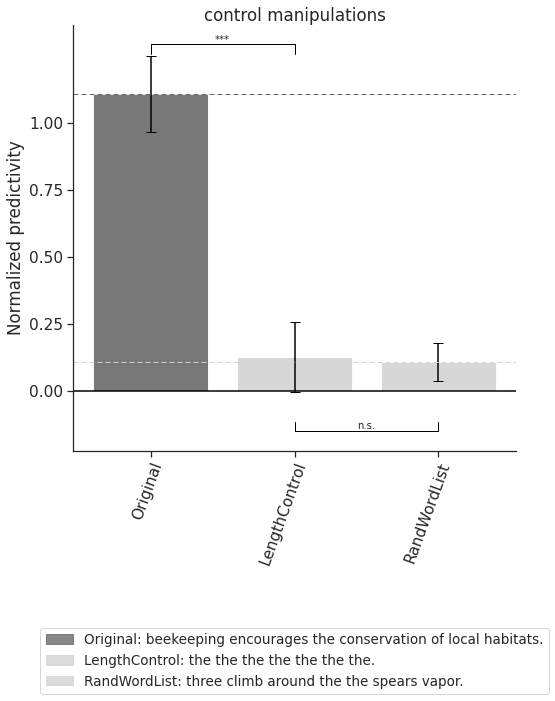

In [57]:
import math

categories = ["word-order", "information-loss", "semantic-distance"]
if randomnouns:
    categories = ["information-loss"]
if length_control:
    categories = ["control"]
    
num_bars = [len(full_df[full_df["category"] == cat]) for cat in categories]
max_bars = max(num_bars)
nrows = len(categories)

fig2 = plt.figure(constrained_layout=True, figsize=(8*nrows, 11), facecolor='white')
props = [1 + 0.2*x for x in num_bars]
spec2 = GridSpec(ncols=nrows, nrows=1, figure=fig2)
f2_ax = []

to_add = 0
    
for ind, current_category in enumerate(categories):
    #set up subplot
    if ind == 0:
        f2_ax.append(fig2.add_subplot(spec2[0, ind]))
    else:
        f2_ax.append(fig2.add_subplot(spec2[0, ind], sharey=f2_ax[0]))

    categories = ["original", current_category, "control"]
    plot_df = full_df[full_df["category"].isin(categories)]
    
    if length_control:
        colors = [CAT2COLOR["original"]] + [CAT2COLOR[current_category]] + [CAT2COLOR["control"]]
    else:
        colors = [CAT2COLOR["original"]] + CAT2COLOR[current_category] + [CAT2COLOR["control"]]
    
    x_pos = np.arange(len(plot_df))
    scores = list(plot_df['score'])
    errors = list(plot_df['error'])
    conditions = list(plot_df['condition'])
                
    stimuli = [list(plot_df.loc[plot_df["category"] == cat]["labelname"]) for cat in categories]
    stimuli = plot_utils.flatten_list(stimuli)
    from textwrap import fill
    stimuli = [fill(l, 75) for l in stimuli]
    
    #add empty slots for same bar width
    if len(x_pos) != max_bars + 2: # +2 because of original and random-wl
        to_add = max_bars - num_bars[ind]
        x_pos = np.arange(len(plot_df) + to_add)
        multiplier1 = math.floor(to_add/2)
        multiplier2 = math.ceil(to_add/2)

        insert_at1 = 1
        insert_at2 = -1

        insert_elements1 = [np.nan]*multiplier1
        insert_elements2 = [np.nan]*multiplier2
        #
        scores[insert_at1:insert_at1] = insert_elements1
        scores[insert_at2:insert_at2] = insert_elements2
        #
        errors[insert_at1:insert_at1] = insert_elements1
        errors[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = [""]*multiplier1
        insert_elements2 = [""]*multiplier2
        #
        conditions[insert_at1:insert_at1] = insert_elements1
        conditions[insert_at2:insert_at2] = insert_elements2
        #
        stimuli[insert_at1:insert_at1] = insert_elements1
        stimuli[insert_at2:insert_at2] = insert_elements2

        insert_elements1 = ["white"]*multiplier1
        insert_elements2 = ["white"]*multiplier2
        
        colors[insert_at1:insert_at1] = insert_elements1
        colors[insert_at2:insert_at2] = insert_elements2

    f2_ax[-1].bar(x_pos, scores,
        yerr=errors,
        align='center',
        alpha=0.9, #color intensity
        ecolor='black',
        capsize=5, #error-bar width
        color=colors)
    
    CAT2COND, COND2CAT = plot_utils.get_conditions(randomnouns=randomnouns, length_control=length_control)
    
    #annotate stats 2 original
    for ind_c, cond in enumerate(CAT2COND[current_category]):
        #adjust names for consistency
        if cond == 'sentenceshuffle_random':
            cond = 'sent_random'
        elif cond == 'sentenceshuffle_passage':
            cond = 'sent_passage'
        elif cond == 'sentenceshuffle_topic':
            cond = 'sent_topic'
            
        cond = plot_utils.COND2LABEL[cond]
            
        if cond in ["Original", "RandWordList"]:
            continue

        idx_random = conditions.index("RandWordList") - to_add

        positions = [i for i, score in enumerate(scores) if not np.isnan(score)]
        #print(positions)
        
        #add stats annotations for comparison with original score
        heights = [scores[0]] * len(positions)
        #add height offset to annotations
        height_offset = [0.1 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2original"].item()
        stats_utils.barplot_annotate_brackets(0, ind_c+1, data=label, center=positions, height=heights, fs=10)
        
        #add stats annotations for comparison with random-wl score
        heights = [0] * len(positions)
        #add height offset to annotations
        height_offset = [-0.1 * i for i in range(len(heights))]
        heights = [sum(x) for x in zip(heights, height_offset)]
        label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2random"].item()
        stats_utils.barplot_annotate_brackets(ind_c+1, idx_random, data=label, center=positions, height=heights,
                                             updown="down", fs=10)
    
    #add horizontal lines for original and random-wl
    orig_score = full_df[full_df["condition"]=="Original"]["score"].item()
    random_score = full_df[full_df["condition"]=="RandWordList"]["score"].item()
    f2_ax[-1].axhline(y=orig_score, color=CAT2COLOR["original"], linestyle=':', dashes=(5, 3), linewidth=1)
    f2_ax[-1].axhline(y=random_score, color=CAT2COLOR["control"], linestyle=":", dashes=(5, 3), linewidth=1)
    
    f2_ax[-1].axhline(y=0, color="black")

    # add legend (sample stimuli)
    # map names to colors
    cmap = dict(zip(conditions, colors))
    cmap = {k: v for k, v in cmap.items() if k}
    # create the rectangles for the legend
    from matplotlib.patches import Patch
    patches = [Patch(color=v, label=k, alpha=0.8) for k, v in cmap.items()]
    # remove empty strings from labels
    stimuli = [x for x in stimuli if x]
    # add the legend
    f2_ax[-1].legend(title='', labels=stimuli, handles=patches,
                     loc='upper center', bbox_to_anchor=(0.5, -0.4),
                     title_fontsize=15, prop={'size': 13.5})
    
    
    #f2_ax[-1].set_ylim([-0.1 + -0.1*num_bars[ind], 1.25 + 0.1*num_bars[ind]])
    
    # TICKS
    ## to get current ones: f2_ax[-1].get_yticks()
    if ind == 0:
        yticks = [0, 0.25, 0.5, 0.75, 1]
        f2_ax[-1].set_yticks(yticks)
    #set yticks
    f2_ax[-1].set_xticks(positions)
    xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
    f2_ax[-1].set_xticklabels([x for x in xticknames if x], rotation=70, ha="right", rotation_mode="anchor")
    
    f2_ax[-1].set_ylabel('Normalized predictivity')
    
    f2_ax[-1].set_title(f"{current_category} manipulations",pad=0.5)

    plt.tight_layout()

save=True
if save:
    if not (randomnouns or length_control):
        plt.savefig(f'results_paper/match2brain/{approach}.svg', dpi=180)
        plt.savefig(f'results_paper/match2brain/{approach}.png', dpi=180, bbox_inches='tight')

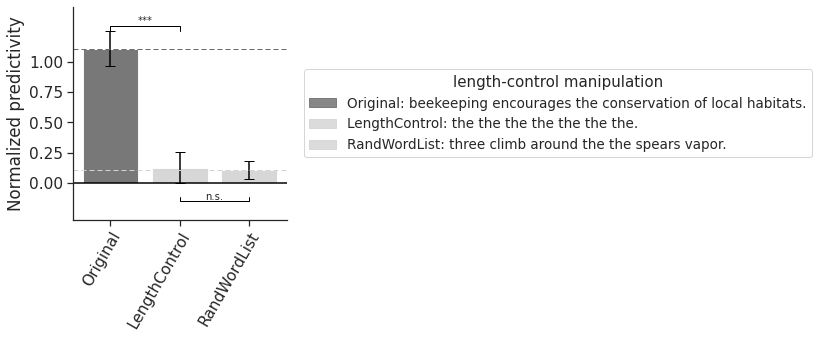

In [58]:
#VERTICAL STACKING
if save and (approach == "TrainIntact-TestPerturbed:contextualized" or length_control):
    categories = ["word-order", "information-loss", "semantic-distance"]
    if randomnouns:
        categories = ["information-loss"]
    if length_control:
        categories = ["control"]
    num_bars = [len(full_df[full_df["category"] == cat]) for cat in categories]
    max_bars = max(num_bars)
    nrows = len(categories)

    if length_control:
        fig2 = plt.figure(constrained_layout=True, figsize=(12, 5*nrows), facecolor='white')
    else:
        fig2 = plt.figure(constrained_layout=True, figsize=(15, 7*nrows), facecolor='white')
    props = [1 + 0.2*x for x in num_bars]
    spec2 = GridSpec(ncols=1, nrows=nrows, figure=fig2, height_ratios=props)
    f2_ax = []

    to_add = 0

    for ind, current_category in enumerate(categories):
        #set up subplot
        f2_ax.append(fig2.add_subplot(spec2[ind, 0]))

        categories = ["original", current_category, "control"]
        plot_df = full_df[full_df["category"].isin(categories)]

        if length_control:
            colors = [CAT2COLOR["original"]] + [CAT2COLOR[current_category]] + [CAT2COLOR["control"]]
        else:
            colors = [CAT2COLOR["original"]] + CAT2COLOR[current_category] + [CAT2COLOR["control"]]

        x_pos = np.arange(len(plot_df))
        scores = list(plot_df['score'])
        errors = list(plot_df['error'])
        conditions = list(plot_df['condition'])

        stimuli = [list(plot_df.loc[plot_df["category"] == cat]["labelname"]) for cat in categories]
        stimuli = plot_utils.flatten_list(stimuli)
        from textwrap import fill
        stimuli = [fill(l, 75) for l in stimuli]

        #add empty slots for same bar width
        if len(x_pos) != max_bars + 2: # +2 because of original and random-wl
            to_add = max_bars - num_bars[ind]
            x_pos = np.arange(len(plot_df) + to_add)
            multiplier = int(to_add/2)

            insert_at1 = 1
            insert_at2 = -1

            insert_elements = [np.nan]*multiplier
            #
            scores[insert_at1:insert_at1] = insert_elements
            scores[insert_at2:insert_at2] = insert_elements
            #
            errors[insert_at1:insert_at1] = insert_elements
            errors[insert_at2:insert_at2] = insert_elements

            insert_elements = [""]*multiplier
            #
            conditions[insert_at1:insert_at1] = insert_elements
            conditions[insert_at2:insert_at2] = insert_elements
            #
            stimuli[insert_at1:insert_at1] = insert_elements
            stimuli[insert_at2:insert_at2] = insert_elements

            insert_elements = ["white"]*multiplier
            colors[insert_at1:insert_at1] = insert_elements
            colors[insert_at2:insert_at2] = insert_elements

        f2_ax[-1].bar(x_pos, scores,
            yerr=errors,
            align='center',
            alpha=0.9, #color intensity
            ecolor='black',
            capsize=5, #error-bar width
            color=colors)

        #annotate stats 2 original
        for ind_c, cond in enumerate(CAT2COND[current_category]):
            #adjust names for consistency
            if cond == 'sentenceshuffle_random':
                cond = 'sent_random'
            elif cond == 'sentenceshuffle_passage':
                cond = 'sent_passage'
            elif cond == 'sentenceshuffle_topic':
                cond = 'sent_topic'

            cond = plot_utils.COND2LABEL[cond]
            
            if cond in ["Original", "RandWordList"]:
                continue

            idx_random = conditions.index("RandWordList") - to_add

            positions = [i for i, score in enumerate(scores) if not np.isnan(score)]

            #add stats annotations for comparison with original score
            heights = [scores[0]] * len(positions)
            #add height offset to annotations
            height_offset = [0.1 * i for i in range(len(heights))]
            heights = [sum(x) for x in zip(heights, height_offset)]
            label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2original"].item()
            stats_utils.barplot_annotate_brackets(0, ind_c+1, data=label, center=positions, height=heights, fs=10)

            #add stats annotations for comparison with random-wl score
            heights = [0] * len(positions)
            #add height offset to annotations
            height_offset = [-0.1 * i for i in range(len(heights))]
            heights = [sum(x) for x in zip(heights, height_offset)]
            label = full_stats_df.loc[full_stats_df["condition"] == cond]["significance2random"].item()
            stats_utils.barplot_annotate_brackets(ind_c+1, idx_random, data=label, center=positions, height=heights,
                                                 updown="down", fs=10)

        #add horizontal lines for original and random-wl
        orig_score = full_df[full_df["condition"]=="Original"]["score"].item()
        random_score = full_df[full_df["condition"]=="RandWordList"]["score"].item()
        f2_ax[-1].axhline(y=orig_score, color=CAT2COLOR["original"], linestyle=':', dashes=(5, 3), linewidth=1)
        f2_ax[-1].axhline(y=random_score, color=CAT2COLOR["control"], linestyle=":", dashes=(5, 3), linewidth=1)

        f2_ax[-1].axhline(y=0, color="black")

        # add legend (sample stimuli)
        # map names to colors
        cmap = dict(zip(conditions, colors))
        cmap = {k: v for k, v in cmap.items() if k}
        # create the rectangles for the legend
        from matplotlib.patches import Patch
        patches = [Patch(color=v, label=k, alpha=0.8) for k, v in cmap.items()]
        # remove empty strings from labels
        stimuli = [x for x in stimuli if x]
        # add the legend
        if length_control:
            f2_ax[-1].legend(title=f'length-control manipulation', labels=stimuli, handles=patches, bbox_to_anchor=(1.05, 0.5),
                     loc='center left', title_fontsize=15, prop={'size': 13.5})
        else:
            f2_ax[-1].legend(title=f'{current_category} manipulations', labels=stimuli, handles=patches, bbox_to_anchor=(1.05, 0.5),
                     loc='center left', title_fontsize=15, prop={'size': 13.5})            


        f2_ax[-1].set_ylim([-0.1 + -0.1*num_bars[ind], 1.25 + 0.1*num_bars[ind]])

        # TICKS
        ## to get current ones: f2_ax[-1].get_yticks()
        yticks = [0, 0.25, 0.5, 0.75, 1]
        f2_ax[-1].set_yticks(yticks)
        #set yticks
        f2_ax[-1].set_xticks(positions)
        xticknames = ["\nFrom".join(elm.split("From")) for elm in conditions]
        f2_ax[-1].set_xticklabels([x for x in xticknames if x], rotation=60, ha="right", rotation_mode="anchor")

        f2_ax[-1].set_ylabel('Normalized predictivity')

        plt.tight_layout()
        if length_control:
            plt.savefig(f'results_paper/SupplementaryInformation/match2brain_approach={approach}_length_control.svg', dpi=300)
            plt.savefig(f'results_paper/SupplementaryInformation/match2brain_approach={approach}_length_control.png', dpi=300)
        elif randomnouns:
            plt.savefig(f'results_paper/SupplementaryInformation/match2brain_approach={approach}_randomnouns.svg', dpi=300)
            plt.savefig(f'results_paper/SupplementaryInformation/match2brain_approach={approach}_randomnouns.png', dpi=300)
        else:
            plt.savefig('results_paper/match2brain/main.svg', dpi=300)
            plt.savefig('results_paper/match2brain/main.png', dpi=300)           
            
            

# get stats within a manipulation condition

In [59]:
subdf = stats_utils.get_stats_df(model_identifier=model_identifier, emb_context=emb_context,
                                     split_coord=split_coord, testonperturbed=testonperturbed,
                                    randomnouns = randomnouns, length_control=length_control)

In [60]:
subdf

,condition,values,category
14,original,0.357018,original
19,original,0.348416,original
18,original,0.372733,original
17,original,0.369114,original
16,original,0.397626,original
15,original,0.395303,original
13,original,0.339043,original
12,original,0.308316,original
11,original,0.292175,original
10,original,0.311779,original


In [61]:
def adjust_name(cond):
    #adjust names for consistency
    if cond == 'sentenceshuffle_random':
        cond = 'sent_random'
    elif cond == 'sentenceshuffle_passage':
        cond = 'sent_passage'
    elif cond == 'sentenceshuffle_topic':
        cond = 'sent_topic'
    return cond

In [62]:
out_dir = os.path.abspath('results_paper/match2brain')

CAT2COND, COND2CAT = plot_utils.get_conditions(testonperturbed=False,
                                                   randomnouns = randomnouns,
                                                   length_control=length_control)

categories = ["word-order", "information-loss", "semantic-distance"]
for ind, current_category in enumerate(categories):
    
    already_tested = [] #list to keep track of which combos were already tested (for correct number of multiple comparisons)
    # NOTE: only done for half of the comparisons, i.e., upper triangle of comparison matrix
    # https://github.com/maximtrp/scikit-posthocs/blob/master/scikit_posthocs/_posthocs.py#L1653
    
    ttests, pvals = [], []
    compare1, compare2 = [], []
    cohens_d = []
    
    for cond1 in CAT2COND[current_category]:
        cond1 = adjust_name(cond1)
        cond1_scores = list(subdf[subdf['condition'] == cond1]["values"])
        
        for cond2 in CAT2COND[current_category]:
            cond2 = adjust_name(cond2)
            
            if cond1 == cond2:
                continue
            
            if set([cond1, cond2]) in already_tested:
                #print(f"Already tested the comparison {cond1} & {cond2}")
                continue
            else:
                #print(f"Testing the comparison {cond1} & {cond2}")
                cond2_scores = list(subdf[subdf['condition'] == cond2]["values"])

                #get ttest
                ttest, pval = scipy.stats.ttest_ind(cond1_scores, cond2_scores)
                #get cohens d
                cohensd = stats_utils.cohens_d(cond1_scores, cond2_scores)

                ttests.append(round(ttest,3))
                pvals.append(pval)
                compare1.append(cond1)
                compare2.append(cond2)
                cohens_d.append(cohensd)

                already_tested.append(set([cond1, cond2]))
    
    _, adjusted_pvals = statsmodels.stats.multitest.fdrcorrection(pvals)
    adjusted_pvals = [round(x,3) for x in adjusted_pvals]
    pvals = [round(x,3) for x in pvals]
    cohens_d = [round(x,3) for x in cohens_d]
    significances = stats_utils.assign_significance_labels(adjusted_pvals)
    
    
    ttest_df = pd.DataFrame({
        "Condition 1" : compare1,
        "Condition 2" : compare2,
        "T-test statistic" : ttests,
        "Adjusted pvalue" : adjusted_pvals,
        "Significance" : significances,
        "Cohen's d" : cohens_d,
        "Unadjusted p value" : pvals
    })
    ttest_df["Manipulation"] = current_category
    ttest_df["Computational design"] = approach
    
    # rename conditions according to new names:
    ttest_df['Condition 1'] = ttest_df['Condition 1'].map(plot_utils.COND2LABEL)
    ttest_df['Condition 2'] = ttest_df['Condition 2'].map(plot_utils.COND2LABEL)
    
    print(ttest_df)
    ttest_df.to_csv(f'{out_dir}/stats_{approach}_within_condition={current_category}_with_ttest.csv',index=False)

StatisticsError: mean requires at least one data point